# Exercise 5
### Lars Kuehmichel, Nicolas Wolf

### 1 GP Optimization of a Toy Problem

In [23]:
import numpy as np
from scipy.stats import describe, norm
import matplotlib.pyplot as plt
import sobol
import optunity as opt
import GPy

import time
import scipy.sparse
import scipy.sparse.linalg
import scipy.spatial

##### 1. Implementation of $f(x, y)$, plot and description of uniform sampling

<span style="color:green;font-weight:bold">
Comment: The sample solution adds the second cosine instead of subtracting it. This may have a small influence on the results.<br>
We used a contourplot instead of a heatmap since, in our opinion, the multiple local minima are more visible in a contour plot.
</span>

In [2]:
def f(x, y):
    return x**2 - x + y**2 + y - np.cos(2*np.pi*x - np.pi) - np.cos(2*np.pi*y + np.pi) + 2.5

def ff(q):
    z = f(q[:, 0], q[:, 1])
    return np.expand_dims(z, -1)

In [3]:
def plot_f(mark_min=False, extra_points=None):
    x = y = np.linspace(-6, 6, 200)
    xx, yy = np.meshgrid(x, y)

    z = f(xx, yy)

    plt.figure(figsize=(9, 9))
    levels = np.linspace(1, 75, 15)
    CS = plt.contour(xx, yy, z, levels=levels)

    if mark_min:
        i = np.argmin(z)
        ii = np.unravel_index(i, xx.shape)
        plt.plot(xx[ii], yy[ii], marker="o", color="magenta", markersize=10)

    if extra_points is not None:
        colors = list(range(len(extra_points)))
        plt.scatter(extra_points[:, 0], extra_points[:, 1], marker="x", c=colors, cmap="autumn")

    plt.title("$f(x, y)$")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

(1200, 1200)


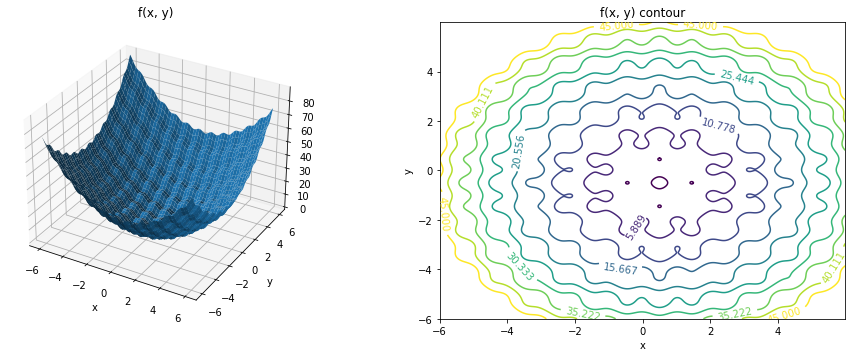

In [4]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(221, projection='3d')
x = y = np.arange(-6.0, 6.0, 0.01)
X, Y = np.meshgrid(x, y)
zs = np.array(f(np.ravel(X), np.ravel(Y)))
Z = zs.reshape(X.shape)
print(Z.shape)
ax.plot_surface(X, Y, Z)
ax.set_title("f(x, y)")
ax.set_xlabel("x")
ax.set_ylabel("y")

contour_plot = fig.add_subplot(222)
levels = np.linspace(1, 45, 10)
CS = contour_plot.contour(X, Y, Z, levels=levels)
contour_plot.clabel(CS, inline=1, fontsize=10)

plt.plot()
plt.xlabel("x")
plt.ylabel("y")
plt.title("f(x, y) contour");

<span style="color:green;font-weight:bold">
Comment: The sample solution used uniformly distributed values in $[0,1]^2$ instead of $[-6,6]^2$ what was asked for in the exercise. This is the reason why our values in the 'describe'-method are so different.
</span>

In [5]:
x = np.random.uniform(-6, 6, 60)
y = np.random.uniform(-6, 6, 60)
z = f(x, y)

describe(z)

DescribeResult(nobs=60, minmax=(3.435584049815147, 70.93979748521342), mean=28.972437152124158, variance=291.463237766527, skewness=0.4422905920287848, kurtosis=-0.5605294301099817)

<span style="color:green;font-weight:bold">
Comment: Essentially equal
</span>

##### 2. Expected improvement

In [6]:
def expected_improvement(q1, q2, E_best, model):
    mean_q, var_q = model.predict(np.array([q1, q2]).reshape(-1,1).T)
    mean_q = mean_q[0][0]
    std_q = np.sqrt(var_q[0][0])
    gamma_q = (E_best - mean_q) / std_q
    return std_q * (gamma_q * norm.cdf(gamma_q, loc=mean_q, scale=std_q) + norm.pdf(gamma_q, loc=mean_q, scale=std_q))

##### 3. and 4. Sobol sampled initial training set

In [7]:
def semi_random_sobol(n, *, lo, hi, split=False):
    if not isinstance(lo, np.ndarray):
        lo = np.array(lo)
    if not isinstance(hi, np.ndarray):
        hi = np.array(hi)

    d = len(lo)
        
    s = np.array([
        sobol.i4_sobol(d, i)[0] for i in range(n)
    ])

    q = s * (hi - lo) + lo

    if split:
        x = q[:, 0]
        y = q[:, 1]

        return x, y

    return q

In [8]:
Q = semi_random_sobol(30, lo=(-6, -6), hi=(6, 6))
E = ff(Q)

print(Q.shape)
print(E.shape)

(30, 2)
(30, 1)


##### 5. GPy model and kernel

In [9]:
kernel = GPy.kern.RBF(2) + GPy.kern.White(2)

model = GPy.models.GPRegression(Q, E, kernel=kernel)
model.optimize()

print(model)


Name : GP regression
Objective : 78.08645392404978
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  sum.rbf.variance         |  168100.80457572208  |      +ve      |        
  sum.rbf.lengthscale      |   23.77359708624776  |      +ve      |        
  sum.white.variance       |  0.5649215107701685  |      +ve      |        
  Gaussian_noise.variance  |  0.5649215107701685  |      +ve      |        


##### 6., 7., and 8. Optimization with a single utility function over 30 iterations

The uncertainty in the resulting function is very high, and it does not accurately follow the
objective function.

<span style="color:green;font-weight:bold">
    Comment: We didn't create a function for the optimization, which would be better, but copy-pasted this cell later.<br>
    Also we create the kernel in each iteration. This could have been moved outside of the loop<br><br>
    
    Our plot of the predicted and actual values look very different from the plot in the sample solution. There are a few differences in our code, but changing those don't change the shape of the plot: As mentioned above, we subtract the second cosine. We use the default value for 'max_f_eval'. We use 'predict' instead of 'predict_noiseless'. And we define our 'E_best' as the minimum of the newly predicted values for all points in the set - the sample solution uses 'model.Y' which contains the predicted values from previous models.<br>
    But: Our added points cluster around the global minimum, instead of clustering bottom left of it.
</span>

In [10]:
Q_new = Q.copy()
E_new = E.copy()
predicted_mu = []
predicted_var = []
actual = []
for i in range(30):
    model = GPy.models.GPRegression(Q_new, E_new, kernel=GPy.kern.RBF(2)+GPy.kern.White(2))
    model.optimize()
    
    E_best = np.min(model.predict(Q_new)[0])
    
    maximum = opt.maximize(lambda q1, q2: expected_improvement(q1, q2, E_best, model), q1=[-6,6], q2=[-6,6])[0]
    q = np.array([maximum['q1'], maximum['q2']]).reshape(-1,1).T
    Q_new = np.row_stack((Q_new, q))
    E_new = np.append(E_new, ff(q), axis=0)
    
    predicted = model.predict(q)
    predicted_mu.append(predicted[0])
    predicted_var.append(predicted[1])
    actual.append(E_new[-1])
    
    print(Q_new[-1], E_new[-1])
    
predicted_mu = np.squeeze(np.array(predicted_mu))
predicted_var = np.squeeze(np.array(predicted_var))
actual = np.squeeze(np.array(actual))

[ 0.76265625 -0.05633893] [3.28325902]
[ 0.49710938 -0.30581132] [0.69435271]
[ 0.45609375 -0.36421875] [0.40055421]
[ 0.44372207 -0.52214653] [0.07519294]
[ 0.36597904 -0.63779412] [0.72299352]
[ 0.27046875 -0.08109375] [2.97288763]
[ 0.10906711 -0.72722933] [2.83611322]
[ 0.58936144 -0.57679687] [0.28158802]
[ 0.60207263 -0.3900648 ] [0.45043778]
[ 0.2184433  -0.72164062] [2.14813295]
[ 0.5615625 -0.5146875] [0.08214315]
[ 0.14701164 -0.07710937] [3.7912199]
[ 0.2046316  -0.37992188] [1.6542419]
[ 0.40725667 -0.58821994] [0.33114918]
[ 0.48343906 -0.69454947] [0.70213269]
[ 0.59007625 -0.52242187] [0.17445264]
[ 0.23375103 -0.90140625] [3.14811234]
[ 0.4453125 -0.3984375] [0.26855407]
[ 0.5302743  -0.69046875] [0.68984749]
[ 0.48766411 -0.89648438] [1.95619123]
[-0.02671875 -1.0115774 ] [4.52244089]
[-0.01992434 -0.8888326 ] [4.17950334]
[0.30505846 0.03745893] [2.96021091]
[ 0.46195313 -0.52899182] [0.04727154]
[ 0.3662532  -0.65236844] [0.79822525]
[ 0.41273437 -0.45770454] [0.1910

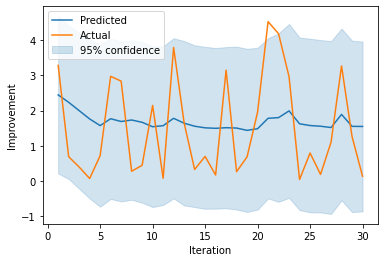

In [12]:
predicted_sigma = np.sqrt(predicted_var)

iterations = 1 + np.arange(30)

confidence = 1.95996
confidence_percent = 95

plt.plot(iterations, predicted_mu, label="Predicted", color="C0")
plt.fill_between(iterations,
                 predicted_mu - confidence * predicted_sigma,
                 predicted_mu +  confidence * predicted_sigma,
                 label=f"{confidence_percent}% confidence",
                 color="C0",
                 alpha=0.2)
plt.plot(iterations, actual, label="Actual", color="C1")
plt.xlabel("Iteration")
plt.ylabel("Improvement")
plt.legend()
plt.show()

##### 9. Marking the GP function values and the global optimum

We marked the global optimum with a big magenta circle, and the explored points with an x,
ranging in color from red (small iteration number) to yellow (high iteration number).

We can see that the optimization does not explore very far, and instead stays within local minima.

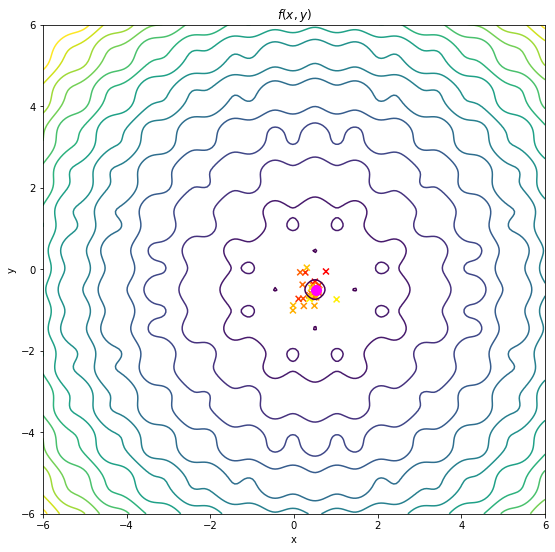

In [14]:
plot_f(mark_min=True, extra_points=Q_new[30:])

##### 10. Repeat the experiment with alternating utility functions

The function is now approximated a lot better, and with a lot higher accuracy. The 95% confidence
interval is barely even visible in the plot. We can also see that the model is much more explorative,
since it moves to the edge of the plot (where high function values are found) very quickly.

<span style="color:green;font-weight:bold">
    Comment: Same as above. We also plotted the values for those iterations where the variance is maximized. This makes it more difficult to see the improvement though.
</span>

In [18]:
def GPy_variance(q1, q2, model):
    mean_q, var_q = model.predict(np.array([q1, q2]).reshape(-1,1).T)
    return var_q
Q_new = Q.copy()
E_new = E.copy()
predicted_mu = []
predicted_var = []
actual = []
for i in range(30):
    model = GPy.models.GPRegression(Q_new, E_new, kernel=GPy.kern.RBF(2)+GPy.kern.White(2))
    model.optimize()
    
    E_best = np.min(model.predict(Q_new)[0])
    
    if i % 2 == 0:
        maximum = opt.maximize(lambda q1, q2: expected_improvement(q1, q2, E_best, model), q1=[-6,6], q2=[-6,6])[0]
    else:
        maximum = opt.maximize(lambda q1, q2: GPy_variance(q1, q2, model), q1=[-6,6], q2=[-6,6])[0]
    q = np.array([maximum['q1'], maximum['q2']]).reshape(-1,1).T
    Q_new = np.row_stack((Q_new, q))
    E_new = np.append(E_new, ff(q), axis=0)
    
    predicted = model.predict(q)
    predicted_mu.append(predicted[0])
    predicted_var.append(predicted[1])
    actual.append(E_new[-1])
    
    print(Q_new[-1], E_new[-1])
    
predicted_mu = np.squeeze(np.array(predicted_mu))
predicted_var = np.squeeze(np.array(predicted_var))
actual = np.squeeze(np.array(actual))

[ 0.14016369 -0.52324554] [1.77730097]
[-5.9934375   1.18961996] [48.38903988]
[ 0.87210938 -0.74129225] [2.83615036]
[5.62023714 2.91366283] [39.99840924]
[ 0.63375    -0.75382875] [1.43918976]
[-3.60867187 -5.85929592] [47.46144085]
[ 0.51304688 -0.98404467] [2.23280675]
[ 5.85727604 -4.6809375 ] [48.38434678]
[-0.26273438 -0.26273438] [2.47820452]
[-5.5546875  5.6015625] [74.14355407]
[ 0.37029849 -0.5165625 ] [0.33659366]
[ 0.34078125 -5.91890625] [31.72290594]
[ 0.11390625 -0.51225657] [1.90682045]
[5.07351562 5.51852976] [59.04171735]
[ 0.59103437 -0.08666729] [2.19366572]
[0.36914062 5.71289062] [39.70547499]
[ 0.40888768 -0.91921875] [2.21741464]
[-0.16734375  5.95455251] [45.5624125]
[ 0.32132813 -0.80367187] [2.02169992]
[-5.5546875  5.6015625] [74.14355407]
[ 0.7021875  -0.50694641] [0.7459639]
[-0.67804687 -5.79366101] [31.24469276]
[ 0.05109375 -0.76921875] [3.34336771]
[ 5.81491848 -1.7425117 ] [32.14183847]
[ 0.61564878 -1.03453125] [2.52824423]
[ 5.67703125 -4.89315268]

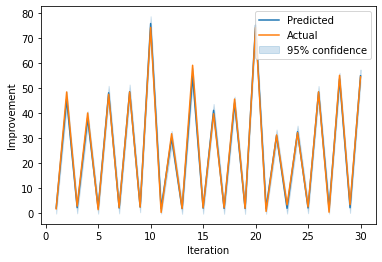

In [19]:
predicted_sigma = np.sqrt(predicted_var)

iterations = 1 + np.arange(30)

confidence = 1.95996
confidence_percent = 95

plt.plot(iterations, predicted_mu, label="Predicted", color="C0")
plt.fill_between(iterations,
                 predicted_mu - confidence * predicted_sigma,
                 predicted_mu +  confidence * predicted_sigma,
                 label=f"{confidence_percent}% confidence",
                 color="C0",
                 alpha=0.2)
plt.plot(iterations, actual, label="Actual", color="C1")
plt.xlabel("Iteration")
plt.ylabel("Improvement")
plt.legend()
plt.show()

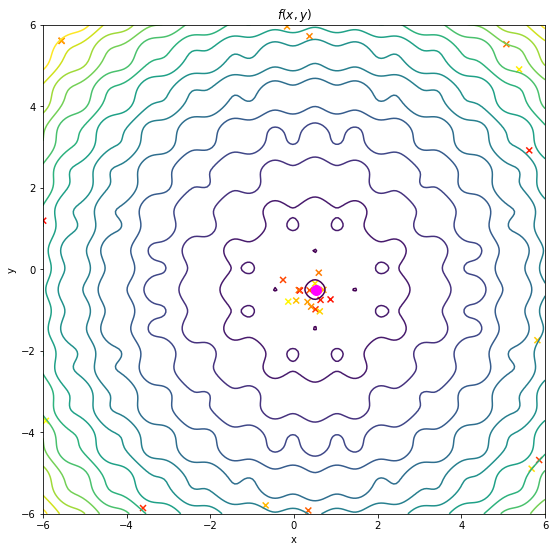

In [20]:
plot_f(mark_min=True, extra_points=Q_new[30:])

##### 11. Plotting the GP model before and after optimization

<span style="color:green;font-weight:bold">
    Comment: Essentially equal
</span>

{'dataplot': [<matplotlib.collections.PathCollection at 0x2054bafb7c0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x2054bafbbb0>]}

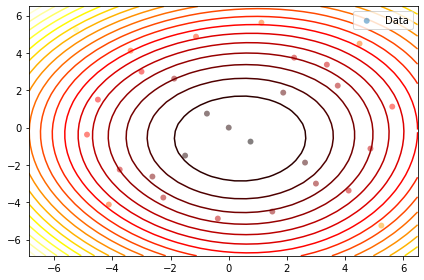

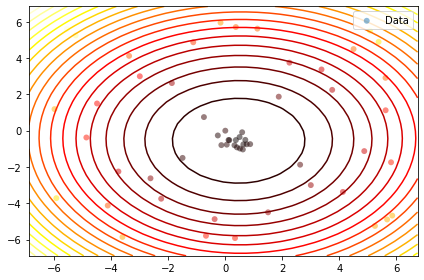

In [24]:
model = GPy.models.GPRegression(Q, E, kernel=GPy.kern.RBF(2)+GPy.kern.White(2))
model.optimize()
model.plot()

model = GPy.models.GPRegression(Q_new, E_new, kernel=GPy.kern.RBF(2)+GPy.kern.White(2))
model.optimize()
model.plot()

##### 12. Requirements for the function f(x, y)

$f(x, y)$ must be a smooth function.

### 2. Reconstruction of a Corrupted Image

The code uses a conjugate gradient method to apply the inverse of $K$. It uses sparse matrices, which is a good
idea since most entries in $K$ are zero (only near-neighbours are non-zero).

<span style="color:green;font-weight:bold">
    Comment: We forgot to change the 'limit' in the new kernel. Therefore the reconstructed images look different.
</span>

In [26]:
opt_print = lambda *args, **kwargs: None  # silence output

# opt_print = print # for debugging

def gaussian_kernel(data, sigma, max_distance):
    """Compute the gaussian kernel matrix.

    :param data: data matrix
    :param sigma: parameter sigma of the gaussian kernel
    :return: gaussian kernel matrix
    """
    assert len(data.shape) == 2
    assert sigma > 0

    factor = -0.5 / (sigma ** 2)
    limit = np.exp(factor * max_distance ** 2)
    # Find the pairwise squared distances and compute the Gaussian kernel.
    K = []
    for k in data:
        d = np.exp(factor * np.sum((data - k) ** 2, axis=1))
        d[d < limit] = 0.0  # truncate the Gaussian
        d = scipy.sparse.csc_matrix(d[:, None])
        K.append(d)
    K = scipy.sparse.hstack(K)
    return K

def generalized_exp_kernel(data, sigma, gamma, max_distance):
    assert len(data.shape) == 2
    assert sigma > 0

    factor = 1 / (sigma ** 2)
    limit = np.exp(factor * max_distance ** 2)
    # Find the pairwise squared distances and compute the Gaussian kernel.
    K = []
    for k in data:
        d = np.exp(-np.sqrt(factor * np.sum((data - k) ** 2, axis=1))**gamma)
        d[d < limit] = 0.0  # truncate the Gaussian
        d = scipy.sparse.csc_matrix(d[:, None])
        K.append(d)
    K = scipy.sparse.hstack(K)
    return K


def compute_alpha(train_x, train_y, tau, sigma, gamma, max_distance, verbose=False):
    """Compute the alpha vector of the ridge regressor.

    :param train_x: training x data
    :param train_y: training y data
    :param tau: parameter tau of the ridge regressor
    :param sigma: parameter sigma of the gaussian kernel
    :param verbose: Print debugging information?
    :return: alpha vector
    """
    if verbose: print("Building input kernel matrix")
    K = generalized_exp_kernel(train_x, sigma, gamma, max_distance)
    if verbose: print("Sparsity is: %.2f%%" % (
            float(100 * K.nnz) / (K.shape[0] * K.shape[1])))
    M = K + tau * scipy.sparse.identity(train_x.shape[0])
    y = scipy.sparse.csc_matrix(train_y[:, None])
    if verbose: print("Solving sparse system")
    alpha = scipy.sparse.linalg.cg(M, train_y)
    if verbose: print("Done computing alpha")
    return alpha[0]


class KernelRidgeRegressor(object):
    """Kernel Ridge Regressor.
    """

    def __init__(self, tau, sigma, gamma):
        self.dim = None
        self.train_x = None
        self.alpha = None
        self.mean_y = None
        self.std_y = None
        self.tau = tau
        self.sigma = sigma
        self.gamma = gamma
        self.scale = -0.5 / sigma**2
        self.max_distance = 4.0*sigma

    def train(self, train_x, train_y, verbose=False):
        """Train the kernel ridge regressor.

        :param train_x: training x data
        :param train_y: training y data
        """
        assert len(train_x.shape) == 2
        assert len(train_y.shape) == 1
        assert train_x.shape[0] == train_y.shape[0]

        self.dim = train_x.shape[1]
        self.train_x = train_x.astype(np.float32)
        self.tree = scipy.spatial.cKDTree(self.train_x)

        self.mean_y = train_y.mean()
        self.std_y = train_y.std()
        train_y_std = (train_y - self.mean_y) / self.std_y

        self.alpha = compute_alpha(self.train_x, train_y_std, self.tau,
                                   self.sigma, self.gamma, self.max_distance,
                                   verbose=verbose)


    def predict_single(self, pred_x):
        """Predict the value of a single instance.

        :param pred_x: x data
        :return: predicted value of pred_x
        """
        assert len(pred_x.shape) == 1
        assert pred_x.shape[0] == self.dim
        indices = np.asarray(
            self.tree.query_ball_point(pred_x, self.max_distance),
            dtype=np.dtype("i8"))
        dist = np.sum((self.train_x[indices] - pred_x) ** 2, axis=1)
        kappa = np.exp(self.scale * dist)
        pred_y = np.dot(kappa, self.alpha[indices])
        return self.std_y * pred_y + self.mean_y

    def predict(self, pred_x):
        """Predict the values of pred_x.

        :param pred_x: x data
        :return: predicted values of pred_x
        """
        assert len(pred_x.shape) == 2
        assert pred_x.shape[1] == self.dim
        pred_x = pred_x.astype(np.float32)
        return np.array([self.predict_single(x) for x in pred_x])


def kernel_ridge_regression(tau, sigma, gamma, verbose=False):
    # Load the image.
    im_orig = np.squeeze(plt.imread("cc_90.png"))

    # Make a copy, so both the original and the regressed image can be shown afterwards.
    im = np.array(im_orig)

    # Find the known pixels and the pixels that shall be predicted.
    known_ind = np.where(im != 0)
    # predict everywhere, use im == 0 to predict only unfilled values
    unknown_ind = np.where(im >= 0)
    known_x = np.array(known_ind).transpose()
    known_y = np.array(im[known_ind])
    pred_x = np.array(unknown_ind).transpose()

    # Train and predict with the given regressor.
    start = time.time()
    if verbose: print("Training...")
    r = KernelRidgeRegressor(tau, sigma, gamma)
    r.train(known_x, known_y, verbose=verbose)
    if verbose: print("Done training.")

    if verbose: print("Predicting... ", end="")
    pred_y = r.predict(pred_x)
    if verbose: print("Done.")

    # Write the predicted values back into the image and show the result.
    im[unknown_ind] = pred_y
    stop = time.time()
    if verbose: print("Train and predict took %.02f seconds." % (stop - start))
    if verbose: print(im.shape)

    return im

In [27]:
result = kernel_ridge_regression(0.8, 3.0, 1.0, verbose=True)

Training...
Building input kernel matrix
Sparsity is: 0.00%
Solving sparse system
Done computing alpha
Done training.
Predicting... Done.
Train and predict took 9.51 seconds.
(338, 250)


(338, 250)


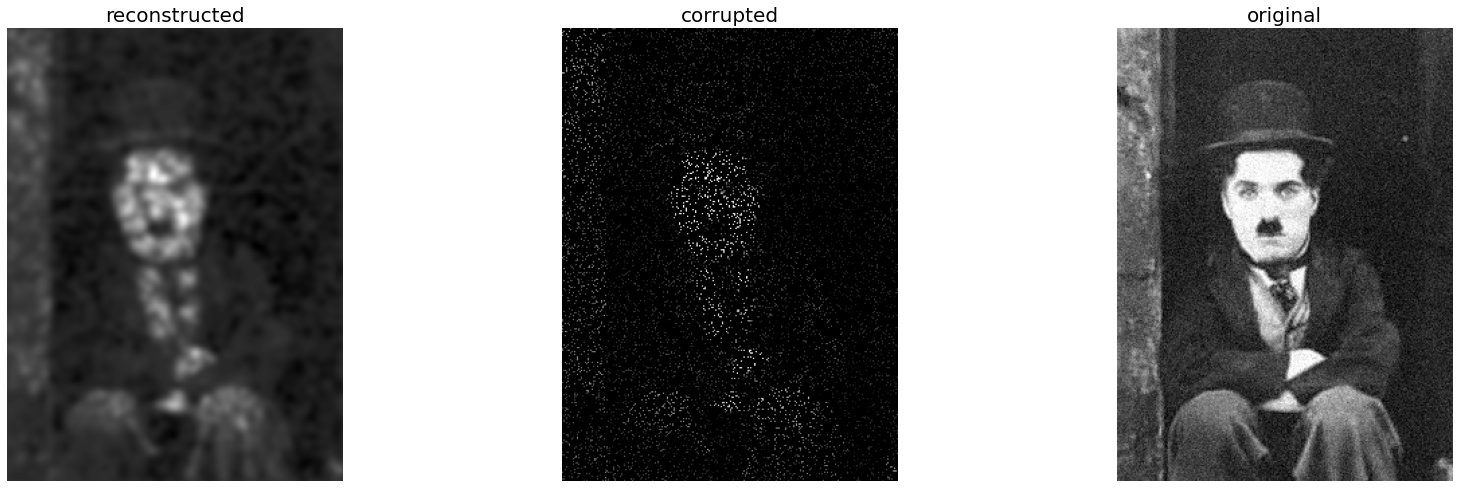

In [28]:
print(result.shape)
fig, axs = plt.subplots(1,3,figsize=(2.5*338/30, 250/30))
axs[0].imshow(result, cmap="gray")
axs[0].axis("off")
axs[0].set_title("reconstructed", fontsize=20)
axs[1].imshow(np.squeeze(plt.imread("cc_90.png")), cmap="gray")
axs[1].axis("off")
axs[1].set_title("corrupted", fontsize=20)
axs[2].imshow(np.squeeze(plt.imread("charlie-chaplin.jpg")), cmap="gray")
axs[2].axis("off")
axs[2].set_title("original", fontsize=20);

### 3. Optimization of Hyperparameters

<span style="color:green;font-weight:bold">
    Comment: Same differences for the optimization described above. Otherwise equivalent
</span>

In [31]:
B = np.squeeze(plt.imread("charlie-chaplin.jpg"))
B_mean = np.mean(B)
B_diff = B - B_mean

In [32]:
def cor(tau, sigma, gamma):
    A = kernel_ridge_regression(tau, sigma, gamma)
    A_diff = A - np.mean(A)
    return np.sum(A_diff * B_diff) / np.sqrt(np.sum(A_diff**2) * np.sum(B_diff**2))

In [33]:
Q = semi_random_sobol(30, lo=(0.005, 1, 1), hi=(1, 7, 4))
E = np.array([1-cor(*theta) for theta in Q]).reshape(-1,1)

print(Q.shape)
print(E.shape)

(30, 3)
(30, 1)


In [41]:
def expected_improvement(q1, q2, q3, E_best, model):
    mean_q, var_q = model.predict(np.array([q1, q2, q3]).reshape(-1,1).T)
    mean_q = mean_q[0][0]
    std_q = np.sqrt(var_q[0][0])
    gamma_q = (E_best - mean_q) / std_q
    return std_q * (gamma_q * norm.cdf(gamma_q, loc=mean_q, scale=std_q) + norm.pdf(gamma_q, loc=mean_q, scale=std_q))
def GPy_variance(q1, q2, q3, model):
    mean_q, var_q = model.predict(np.array([q1, q2, q3]).reshape(-1,1).T)
    return var_q
Q_new = Q.copy()
E_new = E.copy()
predicted_mu = []
predicted_var = []
actual = []
for i in range(30):
    model = GPy.models.GPRegression(Q_new, E_new, kernel=GPy.kern.Matern52(3))
    model.optimize()
    
    E_best = np.min(model.predict(Q_new)[0])
    
    if i % 2 == 0:
        maximum = opt.maximize(lambda q1, q2, q3: expected_improvement(q1, q2, q3, E_best, model), 
                               q1=[0.005, 1], q2=[1, 7], q3=[1, 4])[0]
    else:
        maximum = opt.maximize(lambda q1, q2, q3: GPy_variance(q1, q2, q3, model), 
                               q1=[0.005, 1], q2=[1, 7], q3=[1, 4])[0]
        
    q = np.array([maximum['q1'], maximum['q2'], maximum['q3']]).reshape(-1,1).T
    Q_new = np.row_stack((Q_new, q))
    E_new = np.append(E_new, np.array([1-cor(*q[0])]).reshape(-1,1), axis=0)
    
    predicted = model.predict(q)
    predicted_mu.append(predicted[0])
    predicted_var.append(predicted[1])
    actual.append(E_new[-1])
    
    print(Q_new[-1], E_new[-1])
    
predicted_mu = np.squeeze(np.array(predicted_mu))
predicted_var = np.squeeze(np.array(predicted_var))
actual = np.squeeze(np.array(actual))

[0.61066244 3.30558036 1.13235514] [0.10810407]
[0.86878631 6.68425474 3.93519887] [0.13629755]
[0.56565918 5.14257812 2.54980469] [0.11756563]
[0.20716768 1.12279467 1.89373047] [0.24121855]
[0.61983068 2.99078549 1.93767578] [0.11010925]
[0.49879046 1.01335938 3.93035613] [0.26972218]
[0.14030453 3.08082331 3.85131432] [0.1093494]
[0.69289846 1.1115482  1.62490875] [0.24395924]
[0.15588318 3.45097384 3.37469255] [0.10772245]
[0.81961738 6.97867187 3.38957031] [0.14013434]
[0.80955078 2.8984375  2.74609375] [0.11106303]
[0.14838105 6.72224773 1.44013804] [0.13679139]
[0.37013496 3.62747668 3.36365562] [0.10763633]
[0.1160341  4.85438962 1.1670683 ] [0.11467973]
[0.17067139 4.79980469 2.50439453] [0.11416766]
[0.95135771 4.65589844 3.27619141] [0.11288938]
[0.57051758 1.36328125 2.77539062] [0.19524429]
[0.27929381 5.74644987 1.00318239] [0.12443474]
[0.19544922 5.1015625  1.36328125] [0.11713711]
[0.74001738 1.45247789 3.98957031] [0.18260335]
[0.4281665  5.61425781 1.07177734] [0.122

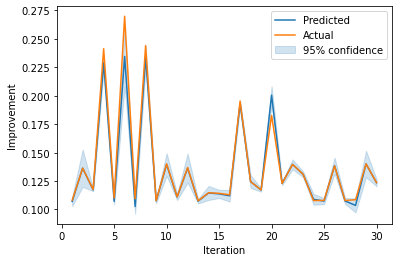

In [42]:
predicted_sigma = np.sqrt(predicted_var)

iterations = 1 + np.arange(30)

confidence = 1.95996
confidence_percent = 95

plt.plot(iterations, predicted_mu, label="Predicted", color="C0")
plt.fill_between(iterations,
                 predicted_mu - confidence * predicted_sigma,
                 predicted_mu +  confidence * predicted_sigma,
                 label=f"{confidence_percent}% confidence",
                 color="C0",
                 alpha=0.2)
plt.plot(iterations, actual, label="Actual", color="C1")
plt.xlabel("Iteration")
plt.ylabel("Improvement")
plt.legend()
plt.show()

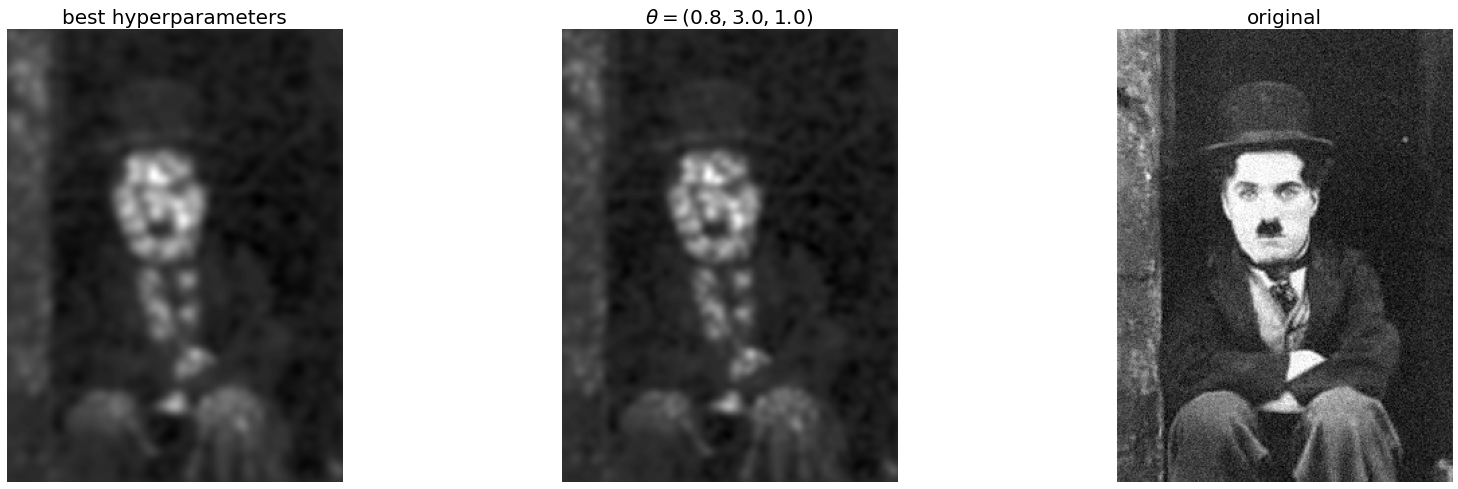

In [45]:
fig, axs = plt.subplots(1,3,figsize=(2.5*338/30, 250/30))
axs[0].imshow(kernel_ridge_regression(*Q_new[np.argmin(E_new)]), cmap="gray")
axs[0].axis("off")
axs[0].set_title("best hyperparameters", fontsize=20)
axs[1].imshow(kernel_ridge_regression(0.8, 3.0, 1.0), cmap="gray")
axs[1].axis("off")
axs[1].set_title(r"$\theta=(0.8, 3.0, 1.0)$", fontsize=20)
axs[2].imshow(np.squeeze(plt.imread("charlie-chaplin.jpg")), cmap="gray")
axs[2].axis("off")
axs[2].set_title("original", fontsize=20);